<a href="https://colab.research.google.com/github/sznajder/Notebooks/blob/master/NormalizingFlow_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normalizing flows exercise
# Authors: Sascha Diefenbacher, Tobias Loesche & Manuel Sommerhalder

## 1.) Motivation

Just as Variational Autoencoders (VAEs) or Generative Adversarial Networks (GANs), Normalizing Flows are **Probabilistic Generative Models (PGMs)**, which describe a probability distribution that we attempt to learn from a set of observed data. 

PGMs are useful for generating new samples from the learned distribution, evaluating the likelihood of new data points etc. 

Normalizing flows are PGMs built on **invertible transformations**. Their advantages are that it is typically possible to efficiently **sample** and **evaluate** the learned distributions. Normalizing flows also are **highly expressive** and come with a **useful latent space representation**, since we have a one-to-one mapping between our input and the latent space. Finally, they are also **easy to train**, since we just need to conduct a simple maximum likelihood training.

In this hands-on exercise we will show examples for using normalizing flows to estimate (conditional) probability densities and to generate new samples. While some instructive mock datasets will be used for getting to know Normalizing Flows, we will also have one dedicated exercise that will use a Particle Physics dataset in the end. As a framework for actually implementing Normalizing Flows quickly, we will use the **TensorFlow probability** package. We hope this tutorial will give you at least a rough idea of how Normalizing Flows work in practice and - most importantly - that you find it instructive and fun :)

## 2.) Normalizing Flows - The general idea (recap)

At the heart of normalizing flows stands the change of random variables formula. Let's say we had a random variable $U$ and now, we apply a simple transformation, defining the transformed random variable as $X$. Then, the change of random variable formula is given by:

$$ p(x) = p(u)\left| \frac{df(u)}{du}\right|^{-1} $$

As an example, let's have a look at the figure below:

<br />
<img src="https://drive.google.com/uc?id=1SoaFiiAtpYMSOepjtZkgZACQeV4Zxwbr" width="250">
<br />

We start out with a uniform distribution $U$ between 0 and 1, and then do a transformation $f(U)=2\cdot U + 1$. This, however leads to a distribution that is not normalized, so in order to get a proper probability distribution, we still need to scale it with $ \left| \left(\frac{df(u)}{du}\right)\right|^{-1} $.

The derivative of $f$ with respect to $u$ is clearly 2, and the inverse is $\frac{1}{2}$, which is exactly the scaling factor that we need for getting a properly normalized distribution.

This, however, is only a simple univariate example. For the multivariate case, instead of the derivative, we need to scale our transformed distribution with the Jacobian determinant:

$$ \left|\det \left( \frac{\partial \boldsymbol{f}}{\partial \boldsymbol{u}} \right)  \right|^{-1} = \left|\det \left( \frac{\partial \boldsymbol{f}^{-1}}{\partial \boldsymbol{x}} \right)  \right| $$

The main idea of normalizing flows is to learn an invertible mapping between a very complex distribution (for example a distribution of a physics variable) and a very simple distribution. Let us consider the "generative" part first, where we attempt to generate new samples from a Normalizing Flow. In this case, we start out with a simple distribution, for example a standard Gaussian, and then repeatedly apply the random variable transformations to acquire a complex distribution similar to the input distribution that we want to approximate. Let's say we apply $k$ transformations $f_{1}...f_{k}$, starting out from a simple distribution $u_{0}$ and going to a complex distribution $u_{k}$, then the change of random variables formula becomes:

$$ p(\boldsymbol{u}_{k}) = p(\boldsymbol{u}_{0})\prod_{i} \left|\det \left( \frac{\partial \boldsymbol{f}_{i}}{\partial \boldsymbol{u}_{i-1}} \right)  \right|^{-1} $$


From this formula, we also see the reason why this method is called "normalizing flows". The random variable "flows" through a series of transformations, while staying normalized by the scaling with the Jacobian determinant.

<br />
<img src="https://drive.google.com/uc?id=1fHZeW9lKGOPl7lZehy8dY0wxLVzjnQFZ" width="1000">
<br />

In a practical case, our "complex" random variables $\boldsymbol{u}_{k}$ would then approximate our input variables.

Since we choose our $\boldsymbol{f}_{i}$ to be invertible, we can also run the Normalizing Flow in the other direction, starting out with our complex input distribution and mapping this distribution tho a standard Gaussian. This is the direction used for density/likelihood estimation (i.e. if you want to evaluate the likelihood of new data under the learned distribution) and also the one used for training.

For training a normalizing flow, remember that our $\boldsymbol{f}_{i}$ are actually neural networks with parameters $\theta$. We train our flow by optimizing these parameters in a negative logarithmic likelihood minimization (which is our loss function then). So we basically take our input samples $\boldsymbol{u}_{k}$, take it "backwards" through the flow (i.e. in the direction of the blue arrows in the picture above) and then tune the parameters of our $\boldsymbol{f}_{i}$ such that the likelihood of the so transformed distribution under a standard Gaussian gets maximized.

To be able to use normalizing flows efficiently, we therefore need functions $f$ that are both **invertible** and **have a tractable Jacobian** that is **easy to compute**. Several methods have been proposed so far and today, you will work mainly with so called "autoregressive flows", where the functions $f$ are chosen in a way such that the Jacobian is guaranteed to be an upper triangular matrix, so we can compute the determinant simply by multiplying its diagonal elements.


## 3.) The TensorFlow Probability package 

Today, we are going to use the TensorFlow Probability library, that is easy to set up and already contains implementations of many of the different flow models. 

In [ ]:
# Let's import some TensorFlow probability as well as some modules first
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
from matplotlib import pyplot as plt
import tensorflow.test as tft
print(f"CUDA available: {tft.is_gpu_available(cuda_only=True)}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
CUDA available: True


Some background about the different modules:

The **bijectors module** contains the implementation of the actual flow models. Each class in this model is already containing the calculation of the Jacobian determinant, so you do not need to do this yourself. The models contain bijective (flow-) equivalents of "standard" layers such as BatchNormalization as well as models used for specific flows (such as the "AutoregressiveNetwork").

The **distributions module** contains many "base distributions" that we can build our flow on (for example a normal distribution as with our example above). The most important class in this module is the `TransformedDistribution`, which takes as parameter a base distribution and an invertible, differentiable transformation (typically one or more transformations from the bijectors module) and models the distribution resulting from applying said tranformation to the base distribution.

As a first step. let's do a very simple example (adapted from TensorFlow probability guide (<a href="https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/AutoregressiveNetwork">link</a>)):

In [ ]:
# Generate a dataset, the density of which we would like to approximate
num_samples = 2000
x2 = np.random.randn(num_samples).astype(dtype=np.float32) * 2.
x1 = np.random.randn(num_samples).astype(dtype=np.float32) + (x2 * x2 / 4.)
data = np.stack([x1, x2], axis=-1)

Let's plot the data

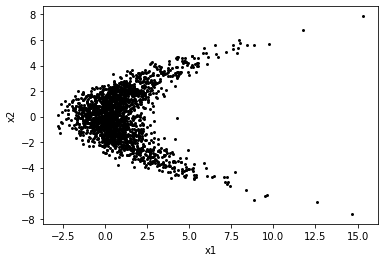

In [ ]:
plt.scatter(data[:, 0], data[:, 1], color='black', marker='.', linewidth=0)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()
plt.close()

The autoregressive models that we will use for this exercise are built with several blocks of MADE networks (Masked Autoencoder for Distribution Estimation, <a href="https://arxiv.org/abs/1502.03509">arxiv</a>). For this very first test, we will not directly build the flow, but just use a single MADE network for estimation of the above density.

In [ ]:
# Density estimation with MADE.
# Since we later want to use a Gaussian as our autoregressive distribution, we need to set
# "params" to 2, such that the MADE network can parameterize its mean and logarithmic standard deviation.
# The "hidden units" parameter tells us that the MADE network has two layers with 10 nodes each.
made = tfb.AutoregressiveNetwork(params=2, hidden_units=[10, 10])

# Create the TransformedDistribution. We will use a normal distribution with mean 0 and standard
# deviation 1 as base distribution.
# The tfd.Sample allows us to define normal distributions in multiple dimensions.
# Since we have two dimensions (x1 and x2), we use tfd.Sample and set sample_shape
# to [2].
# We also define the bijector that transforms this distribution. In this case, it is
# a masked autoregressive flow, just consisting of our single MADE block.
bijector = tfb.MaskedAutoregressiveFlow(made)
distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=bijector)


In [ ]:
# Construct the model:
# We use as input a standard input layer.
# The output is the logarithmic probability (i.e. log likelihood) of our transformed
# distribution:
x_ = tfkl.Input(shape=(2,), dtype=tf.float32)
log_prob_ = distribution.log_prob(x_)
model = tfk.Model(x_, log_prob_)


In [ ]:
# Let's compile the model, using the Adam optimizer.
# The loss is simply the negative log likelihood,
# here simply wrapped in a lambda function.
model.compile(optimizer=tf.optimizers.Adam(),
              loss=lambda _, log_prob: -log_prob)

# let's train the model
batch_size = 25

# since normalizing flows are an unsupervised method,
# we simply provide an array of zeros for the "y"
# parameter here, which has the same number of entries
# as our input data.
model.fit(x=data,
          y=np.zeros((num_samples, 0), dtype=np.float32),
          batch_size=batch_size,
          epochs=20,
          steps_per_epoch=num_samples // batch_size,
          shuffle=True,
          verbose=True)

Epoch 1/20
80/80 [==============================] - 3s 2ms/step - loss: 4.9053
Epoch 2/20
80/80 [==============================] - 0s 2ms/step - loss: 4.7540
Epoch 3/20
80/80 [==============================] - 0s 2ms/step - loss: 4.4892
Epoch 4/20
80/80 [==============================] - 0s 2ms/step - loss: 4.2884
Epoch 5/20
80/80 [==============================] - 0s 2ms/step - loss: 4.2801
Epoch 6/20
80/80 [==============================] - 0s 2ms/step - loss: 4.1889
Epoch 7/20
80/80 [==============================] - 0s 2ms/step - loss: 4.2352
Epoch 8/20
80/80 [==============================] - 0s 2ms/step - loss: 4.2283
Epoch 9/20
80/80 [==============================] - 0s 2ms/step - loss: 4.0680
Epoch 10/20
80/80 [==============================] - 0s 2ms/step - loss: 4.0250
Epoch 11/20
80/80 [==============================] - 0s 2ms/step - loss: 4.1245
Epoch 12/20
80/80 [==============================] - 0s 2ms/step - loss: 4.0119
Epoch 13/20
80/80 [==============================

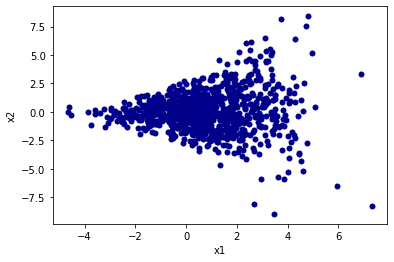

In [ ]:
# Let's use the fitted distribution and sample from it
samples = distribution.sample(1000)
plt.scatter(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()
plt.close()

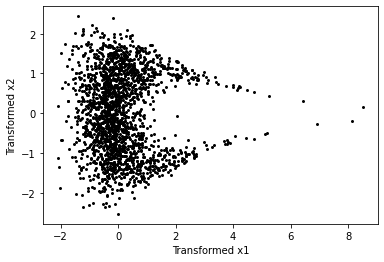

In [ ]:
# Let's also plot how well our data is mapped to the Gaussian base distribution

inv = bijector.inverse(data)
plt.scatter(inv[:, 0], inv[:, 1], color='black', marker='.', linewidth=0)
plt.xlabel("Transformed x1")
plt.ylabel("Transformed x2")
plt.show()
plt.close()

As we can see, our initial density is estimated rather poorly. We also see that our mapped data is far from being Gaussian distributed in the latent space. So what did we do wrong? We actually didn't use a proper flow! For getting to know the TensorFlow probability module, a single MADE network was used here. This would be equivalent of using only a single transformation $f$ instead of using many of them. With the knowledge of how to use the module, we can now start building a powerful flow, consisting of multiple MADE blocks.

# Self-defined MADE block

In [ ]:
# This is simply a copy of the original "AutoregressiveNetwork" class in tfp.bijectors. The only reason we need to do this is that we want to apply a tanh
# on the output log-scale when the Network is called. This allows for better regularization and helps with "inf" and "nan" values that otherwise would
# frequently occur during training.
class Made(tfb.AutoregressiveNetwork):
    def __init__(self, params, event_shape=None, conditional=False, conditional_event_shape=None, conditional_input_layers='all_layers', hidden_units=None,
                 input_order='left-to-right', hidden_degrees='equal', activation=None, use_bias=True,kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint=None, validate_args=False, **kwargs):
        
        super().__init__(params=params, event_shape=event_shape, conditional=conditional, conditional_event_shape=conditional_event_shape,
                         conditional_input_layers=conditional_input_layers, hidden_units=hidden_units, input_order=input_order, hidden_degrees=hidden_degrees,
                         activation=activation, use_bias=use_bias, kernel_initializer=kernel_initializer, bias_initializer=bias_initializer,
                         kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer, kernel_constraint=kernel_constraint, bias_constraint=bias_constraint,
                         validate_args=validate_args, **kwargs)
    
    def call(self, x, conditional_input=None):
        

        result = super().call(x, conditional_input=conditional_input)
        
        shift, log_scale = tf.unstack(result, num=2, axis=-1)

        return shift, tf.math.tanh(log_scale)
    
    def get_config(self):
        
        config = super().get_config().copy()
        
        return config

# Define model and compile

In [ ]:
def compile_MAF_model(num_made, num_inputs, num_cond_inputs=None, made_layers=[128], base_lr=1.0e-3, end_lr=1.0e-4, return_layer_list=False):

  if num_cond_inputs is not None:
    conditional = True
    cond_event_shape = (num_cond_inputs,)
  else:
    conditional = False
    cond_event_shape = None

  made_list = []
  for i in range(num_made):
    made_list.append(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=Made(params=2, hidden_units=made_layers, event_shape=(num_inputs,), conditional=conditional,
                                    conditional_event_shape=cond_event_shape, activation='relu', name=f"made_{i}"), name=f"maf_{i}"))
    
    #made_list.append(tfb.BatchNormalization())
    made_list.append(tfb.Permute(permutation=np.array(np.arange(0, num_inputs)[::-1])))
                     
  # remove final permute layer
  made_chain = tfb.Chain(list(reversed(made_list[:-1])))

  # we want to transform to gaussian distribution with mean 0 and std 1 in latent space
  distribution = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[num_inputs]),
    bijector=made_chain)

  x_ = tfk.layers.Input(shape=(num_inputs,), name="aux_input")
  input_list = [x_]

  if conditional:
    c_ = tfk.layers.Input(shape=(num_cond_inputs,), name="cond_input")
    input_list.append(c_)

    current_kwargs = {}
    for i in range(num_made):
      current_kwargs[f"maf_{i}"] = {'conditional_input' : c_}
    
  else:
    current_kwargs = {}
  
  log_prob_ = distribution.log_prob(x_, bijector_kwargs=current_kwargs)
  
  model = tfk.Model(input_list, log_prob_)
  max_epochs = 100  # maximum number of epochs of the training
  learning_rate_fn = tfk.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
  model.compile(optimizer=tfk.optimizers.Adam(learning_rate=learning_rate_fn),
              loss=lambda _, log_prob: -log_prob)
  
  if return_layer_list:
    return model, distribution, made_list
  else:
    return model, distribution

# Data Generation using Flows

One major advantage of Normalizing Flow Networks is that they are inherently invertible. This means that we can not only use them for density estimation by mapping our data set to a well known distribution like a Normal Gaussian, but we can also do the reverse, mapping the Normal Gaussian to our data distribution. This essentially allows us to generate new data by feeding Gaussian samples backwards through our model. 

One common example used for benchmarking is the so-called 'two moon' dataset, consisting of two interlocking half circles. On the one hand it tests the generative model's ability to replicate a complex structure, on the other hand this data set also features two separate subsets, which our generative model will have to keep separate as well. 



# Load two moon data

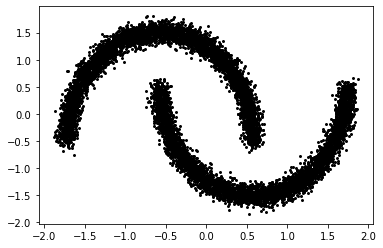

In [ ]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

# for two moons dataset
n = 10000
X_moons, _ = datasets.make_moons(n_samples=n, noise=.05)
X_moons = StandardScaler().fit_transform(X_moons)

plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0)
plt.savefig("./original_two_moons.pdf")
plt.show()
plt.close()

As a first test, let us take our simple Flow and train it on this dataset:

# Train Simple Flow

In [ ]:
#Define two-block made network
num_made = 2
epochs = 10

model, distribution, list_made = compile_MAF_model(num_made, num_inputs=2, return_layer_list=True)

# definie intermediate outputs for later
feat_extraction_dists = []
listR = list(reversed(list_made[:-1]))

made_chain = tfb.Chain([])
dist = tfd.TransformedDistribution(
  distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
  bijector=made_chain)
feat_extraction_dists.append(dist)

for i in range(1, len(listR), 2):
  made_chain = tfb.Chain(listR[0:i])
  dist = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=made_chain)
  feat_extraction_dists.append(dist)

In [ ]:


#as this is once again a unsupervised task, the target vector y is again zeros
batch_size = 32
model.fit(x=X_moons,
          y=np.zeros((X_moons.shape[0], 0), dtype=np.float32),
          batch_size= batch_size,
          epochs=epochs,
          steps_per_epoch=X_moons.shape[0] // batch_size,
          verbose=1,
          shuffle=True)

Epoch 1/10
312/312 [==============================] - 2s 4ms/step - loss: 2.6287
Epoch 2/10
312/312 [==============================] - 1s 4ms/step - loss: 2.5209
Epoch 3/10
312/312 [==============================] - 1s 4ms/step - loss: 2.4666
Epoch 4/10
312/312 [==============================] - 1s 4ms/step - loss: 2.4336
Epoch 5/10
312/312 [==============================] - 1s 4ms/step - loss: 2.4074
Epoch 6/10
312/312 [==============================] - 1s 4ms/step - loss: 2.3852
Epoch 7/10
312/312 [==============================] - 1s 4ms/step - loss: 2.3609
Epoch 8/10
312/312 [==============================] - 1s 4ms/step - loss: 2.3442
Epoch 9/10
312/312 [==============================] - 1s 4ms/step - loss: 2.3265
Epoch 10/10
312/312 [==============================] - 1s 4ms/step - loss: 2.3068


Now that the model is trained we can use it to try and generate new samples. 

Thankfully TensorFlow Probability provides an easy way of doing this, we simply need to call the sample() function on the returned distribution variable

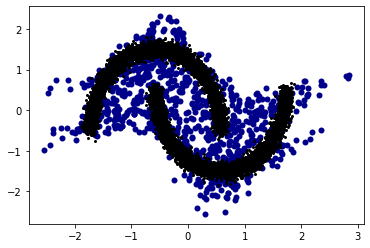

In [ ]:
#generate 1000 new samples
samples = distribution.sample(1000)

#transform them like we did when plotting the original dataset
samples = StandardScaler().fit_transform(samples)

#plot the results
plt.scatter(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0)
plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0)
plt.savefig("./sampled_two_moons.pdf")
plt.show()
plt.close()

Additionally we can use the earlier prepared code to show intermediate steps of the transformations

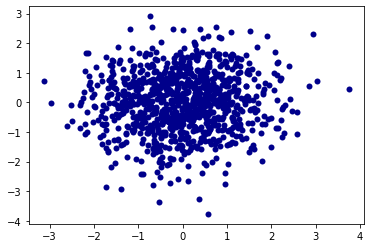

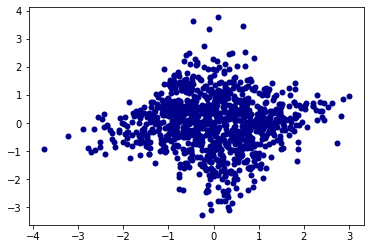

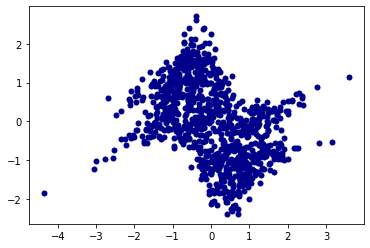

In [ ]:
for d in feat_extraction_dists:
  out = d.sample(1000)
  out = StandardScaler().fit_transform(out)

  plt.scatter(out[:, 0], out[:, 1], color='darkblue', marker='o', linewidth=0)
  plt.show()
  plt.close()

out = distribution.sample(1000)
out = StandardScaler().fit_transform(out)

plt.scatter(out[:, 0], out[:, 1], color='darkblue', marker='o', linewidth=0)
plt.show()
plt.close()


As we can see, the result is somewhat underwhelming. This is because we once again used a very simple setup, that is unable to correctly model the dataset. 

**Task: Modify the Code below to improve the generation result**


Epoch 1/30
312/312 [==============================] - 5s 9ms/step - loss: 2.5785
Epoch 2/30
312/312 [==============================] - 3s 8ms/step - loss: 2.3921
Epoch 3/30
312/312 [==============================] - 3s 8ms/step - loss: 2.2786
Epoch 4/30
312/312 [==============================] - 3s 9ms/step - loss: 2.1972
Epoch 5/30
312/312 [==============================] - 3s 8ms/step - loss: 2.1497
Epoch 6/30
312/312 [==============================] - 3s 8ms/step - loss: 2.1292
Epoch 7/30
312/312 [==============================] - 3s 8ms/step - loss: 2.1095
Epoch 8/30
312/312 [==============================] - 3s 8ms/step - loss: 2.0879
Epoch 9/30
312/312 [==============================] - 3s 8ms/step - loss: 2.0669
Epoch 10/30
312/312 [==============================] - 3s 9ms/step - loss: 2.0463
Epoch 11/30
312/312 [==============================] - 3s 9ms/step - loss: 2.0376
Epoch 12/30
312/312 [==============================] - 3s 9ms/step - loss: 2.0083
Epoch 13/30
312/312 [====

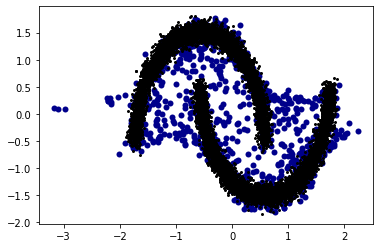

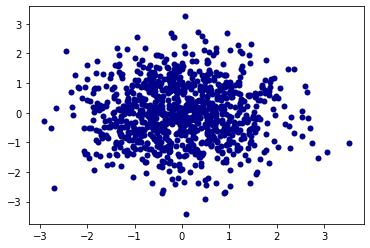

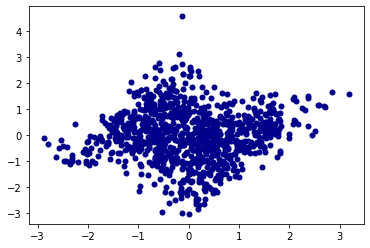

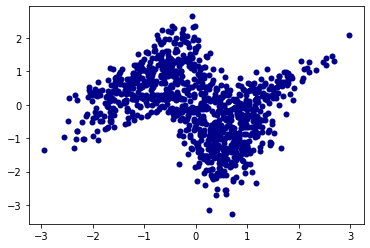

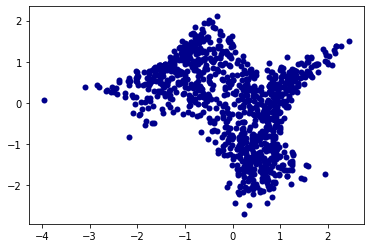

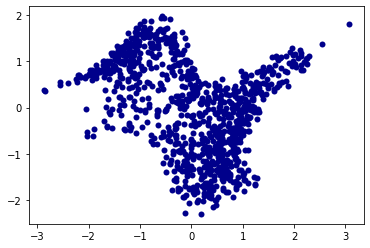

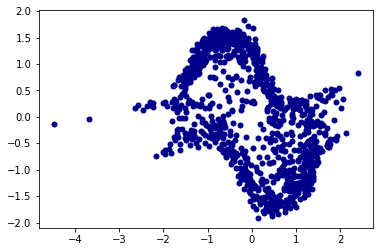

In [ ]:
#Define two-block made network
num_made = 5
epochs = 30

model, distribution, list_made = compile_MAF_model(num_made, num_inputs=2, return_layer_list=True)

# definie intermediate outputs for later
feat_extraction_dists = []
listR = list(reversed(list_made[:-1]))

made_chain = tfb.Chain([])
dist = tfd.TransformedDistribution(
  distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
  bijector=made_chain)
feat_extraction_dists.append(dist)

for i in range(1, len(listR), 2):
  made_chain = tfb.Chain(listR[0:i])
  dist = tfd.TransformedDistribution(
    distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=made_chain)
  feat_extraction_dists.append(dist)


#as this is once again a unsupervised task, the target vector y is again zeros
batch_size = 32
model.fit(x=X_moons,
          y=np.zeros((X_moons.shape[0], 0), dtype=np.float32),
          batch_size= batch_size,
          epochs=epochs,
          steps_per_epoch=X_moons.shape[0] // batch_size,
          verbose=1,
          shuffle=True)


#generate 1000 new samples
samples = distribution.sample(1000)

#transform them like we did when plotting the original dataset
samples = StandardScaler().fit_transform(samples)

#plot the results
plt.scatter(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0)
plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0)
plt.savefig("./sampled_two_moons.pdf")
plt.show()
plt.close()

#plot the intermediate results
for d in feat_extraction_dists:
  out = d.sample(1000)
  out = StandardScaler().fit_transform(out)

  plt.scatter(out[:, 0], out[:, 1], color='darkblue', marker='o', linewidth=0)
  plt.show()
  plt.close()

out = distribution.sample(1000)
out = StandardScaler().fit_transform(out)

plt.scatter(out[:, 0], out[:, 1], color='darkblue', marker='o', linewidth=0)
plt.show()
plt.close()


Now that we have a nicely working model, we can try and adapt this to other problems

**Task: Use what you learned previously to train a generative flow on the first example dataset**

In [ ]:
# Generate a dataset, the density of which we would like to approximate
num_samples = 2000
x2 = np.random.randn(num_samples).astype(dtype=np.float32) * 2.
x1 = np.random.randn(num_samples).astype(dtype=np.float32) + (x2 * x2 / 4.)
data = np.stack([x1, x2], axis=-1)

plt.scatter(data[:, 0], data[:, 1], color='black', marker='.', linewidth=0)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()
plt.close()

In [ ]:
######################
#Add code here
######################



# Conditional Generative Flows

Many generative tasks in particle physics require the generative model to not only generate a random point from the data set, but instead to generate a point with a specific property. One Example is shower simulation, where a generative shower simulator should be able to produce showers for a given particle energy, rather than just for a random one. 

This is where conditional generative models become important. In the previous example the energy value would be the condition given to the model. 

Let us try this principle on flows with our previous two moons data set. As one can see, it is made up of two distinct subsets, (the eponymous moons). Our conditioning will be to which moon a datapoint belongs, e.g. if we tell the model to generate points with the label 0 they should be from the top moon, while points with the label 1 should be from the bottom.

In [ ]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

# for two moons dataset
n = 10000
# the two moons sampling function already returns labels to which moon a data point belongs
X_moons, label_moon = datasets.make_moons(n_samples=n, noise=.05)
X_moons = StandardScaler().fit_transform(X_moons)



plt.scatter(X_moons[:, 0][label_moon==0], X_moons[:, 1][label_moon==0], color='orangered', marker='.', linewidth=0)
plt.scatter(X_moons[:, 0][label_moon==1], X_moons[:, 1][label_moon==1], color='green', marker='.', linewidth=0)


plt.savefig("./original_two_moons.pdf")
plt.show()
plt.close()

In [ ]:

#Define one-block made network
num_made = 10
epochs = 10

model, distribution = compile_MAF_model(num_made, num_inputs=2, num_cond_inputs=1)

#as this is once again an unsupervised task, the target vector y is again zeros during training
batch_size = 32
model.fit(x=[X_moons, label_moon],
          y=np.zeros((X_moons.shape[0], 0), dtype=np.float32),
          batch_size= batch_size,
          epochs=epochs,
          steps_per_epoch=X_moons.shape[0] // batch_size,
          verbose=1,
          shuffle=True)

Now lets see how well our model performs, first by using random labels. This should look like the default two moons set. 

In [ ]:
n_samples = 10000

cond = np.random.randint(2, size=(n_samples,1))
current_kwargs ={}
for i in range(num_made):
    current_kwargs[f"maf_{i}"] = {'conditional_input' : cond}


samples = distribution.sample ( (n_samples, ), bijector_kwargs=current_kwargs)

plt.scatter(samples[:, 0], samples[:, 1], color='darkblue', marker='o', linewidth=0)
plt.scatter(X_moons[:, 0], X_moons[:, 1], color='black', marker='.', linewidth=0)
plt.savefig("./sampled_two_moons.pdf")
plt.show()
plt.close()

We can also test how well our conditioning performs by passing only the label 0 or only the label 1 to our network.


In [ ]:
n_samples = 10000

cond1 = np.ones((n_samples,1))
cond0 = np.zeros((n_samples,1))


current_kwargs0 ={}
for i in range(num_made):
    current_kwargs0[f"maf_{i}"] = {'conditional_input' : cond0}
samples0 = distribution.sample ( (n_samples, ), bijector_kwargs=current_kwargs0)

current_kwargs1 ={}
for i in range(num_made):
    current_kwargs1[f"maf_{i}"] = {'conditional_input' : cond1}
samples1 = distribution.sample ( (n_samples, ), bijector_kwargs=current_kwargs1)

plt.scatter(samples0[:, 0], samples0[:, 1], color='orangered', marker='.', linewidth=0)
plt.scatter(samples1[:, 0], samples1[:, 1], color='green', marker='.', linewidth=0)
plt.savefig("./sampled_two_moons.pdf")
plt.show()
plt.close()

# High energy physics use case

To illustrate the use of normalizing flows, we now want to a apply it to a high energy physics example. For this aim, we use the LHCO 2020 challenge R&D dataset (https://lhco2020.github.io/homepage/). It consists of simulated QCD multijet events in addition to a signal process of a W' boson with a mass of $m_{W'} = 3.5$ TeV decaying into an X boson ($m_{X} = 500$ GeV) and a Y boson ($m_{Y} = 100$ GeV). Specifically, we use the high-level features set, which contains the 4-momenta of the two leading jets, their (1,2,3) subjettiness and a label denoting whether the event is a signal (1) or background (0) process.

While the main purpose of this dataset was an anomaly detection competition, we will continue looking at normalizing flows from the perspective of artificial data generation. Nevertheless, if you manage to solve the advanced exercise in the end, you will also be well prepared to understand and use the ANODE method (Anomaly Detection with Density Estimation, <a href="https://arxiv.org/abs/2001.04990">arxiv</a>). More on this might follow in the anomaly detection workshop.

So let's first download the dataset.

In [ ]:
%%shell
wget https://zenodo.org/record/4536377/files/events_anomalydetection_v2.features.h5

The data is stored as a pandas dataframe. We load the data and pick a random 10% subset for the sake of computation speed. Feel free to use the full data in your own time.

In [ ]:
import pandas as pd

dataset = pd.read_hdf("events_anomalydetection_v2.features.h5")
dataset = dataset.sample(frac=0.1)
print("The variables are:", [col for col in dataset.columns])

We now order the two jets by mass, such that $m_{j1} \leq m_{j2}$. Then we extract four interesting features, which could be used here to distinguish signal from background: $m_{j1}$, $m_{j2}-m_{j1}$, $\tau_{21,1}$, $\tau_{21,2}$

In [ ]:
mj1mj2=np.array(dataset[['mj1','mj2']])
tau21=np.array(dataset[['tau2j1','tau2j2']])/(1e-5+np.array(dataset[['tau1j1','tau1j2']])) # add small number to denominator to avoid division by zero
mjmin=mj1mj2[range(len(mj1mj2)),np.argmin(mj1mj2,axis=1)]
mjmax=mj1mj2[range(len(mj1mj2)),np.argmax(mj1mj2,axis=1)]
tau21min=tau21[range(len(mj1mj2)),np.argmin(mj1mj2,axis=1)]
tau21max=tau21[range(len(mj1mj2)),np.argmax(mj1mj2,axis=1)]
data = np.dstack((mjmin/1000, (mjmax-mjmin)/1000, tau21min, tau21max))[0] # put data together and convert GeV to TeV
labels = np.array(dataset['label'])
print("data.shape =", data.shape)

Let's plot these four features.

In [ ]:
## visualize the 4 extracted variables
fig, ax = plt.subplots(2,2, figsize=(12,8))
_, common_bins, _ = ax[0,0].hist(data[:,0], 100, alpha=0.6, label="data")
ax[0,0].hist(data[:,0][labels==0], common_bins, label="background", edgecolor="red", linewidth=1.3, histtype="step")
ax[0,0].hist(data[:,0][labels==1], common_bins, label="signal", edgecolor="green", linewidth=1.3, histtype="step")
ax[0,0].set_xlabel("lower jet mass (TeV)")
ax[0,0].set_ylabel("events")
ax[0,0].set_yscale("log")
_, common_bins, _ = ax[0,1].hist(data[:,1], 100, alpha=0.6, label="data")
ax[0,1].hist(data[:,1][labels==0], common_bins, label="background", edgecolor="red", linewidth=1.3, histtype="step")
ax[0,1].hist(data[:,1][labels==1], common_bins, label="signal", edgecolor="green", linewidth=1.3, histtype="step")
ax[0,1].set_xlabel("jet mass difference (TeV)")
ax[0,1].set_ylabel("events")
ax[0,1].set_yscale("log")
_, common_bins, _ = ax[1,0].hist(data[:,2], 100, alpha=0.6, label="data")
ax[1,0].hist(data[:,2][labels==0], common_bins, label="background", edgecolor="red", linewidth=1.3, histtype="step")
ax[1,0].hist(data[:,2][labels==1], common_bins, label="signal", edgecolor="green", linewidth=1.3, histtype="step")
ax[1,0].set_xlabel(r"$\tau_{21,1}$")
ax[1,0].set_ylabel("events")
_, common_bins, _ = ax[1,1].hist(data[:,3], 100, alpha=0.6, label="data")
ax[1,1].hist(data[:,3][labels==0], common_bins, label="background", edgecolor="red", linewidth=1.3, histtype="step")
ax[1,1].hist(data[:,3][labels==1], common_bins, label="signal", edgecolor="green", linewidth=1.3, histtype="step")
ax[1,1].set_xlabel(r"$\tau_{21,2}$")
ax[1,1].set_ylabel("events")
leg_handles, leg_labels = ax[0,0].get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, loc='upper right')
fig.tight_layout()
plt.show()

We want train a density estimator to generate such data ourselves. We use the same MAF model as before, just reinstantiate it. This time with 4 input variables. In addition, we increase the complexity of the MADE layers in order to keep up with the more complex task.

In [ ]:
num_made = 15
num_inputs = 4

model, distribution = compile_MAF_model(num_made, num_inputs, made_layers=[128, 128])

Before plugging our data into the MAF, we should preprocess the variables, so the model can learn them more easily. Density estimators tend to have difficulties with sharp  edges and boundaries. We first normalize each variable to lie between 0 and 1, then we apply a logit transformation $\log(\frac{x}{1-x})$ mapping the variables to ($-\infty$, $+\infty$) and then we shift the mean to 0 and divide by the standard deviation. Here we define these three transformations, as well as their inverse functions. Be aware that for computing likelihoods, we would also need to take into account the Jacobian of each transformation. In a purely generative approach, we don't need to worry about this now.

In [ ]:
## defining variable transformations

def normalize_data(in_data, max_val, min_val):
  new_data = (in_data-min_val)/(max_val-min_val)
  mask = np.prod(((new_data < 1) & (new_data > 0 )), axis=1, dtype=bool)
  new_data = new_data[mask]
  return new_data, mask

def logit_data(in_data):
  new_data = np.log(in_data/(1-in_data))
  return new_data

def standardize_data(in_data, mean_val, std_val):
  new_data = (in_data - mean_val)/std_val
  return new_data


## defining their inverse transformations

def normalize_inverse(in_data, max_val, min_val):
  new_data = in_data*(max_val-min_val) + min_val
  return new_data

def logit_inverse(in_data):
  new_data = (1+np.exp(-in_data))**(-1)
  return new_data

def standardize_inverse(in_data, mean_val, std_val):
  new_data = std_val*in_data + mean_val
  return new_data

In [ ]:
## transform data and save max, min, mean, std values for the backtransformation later

max_values = np.max(data, keepdims=True, axis=0)
min_values = np.min(data, keepdims=True, axis=0)

## normalize
transformed_data, mask = normalize_data(data, max_values, min_values)

## logit
transformed_data = logit_data(transformed_data)

## standardize
mean_values = np.mean(transformed_data, keepdims=True, axis=0)
std_values = np.std(transformed_data, keepdims=True, axis=0)
transformed_data = standardize_data(transformed_data, mean_values, std_values)

## apply mask also to labels
transformed_labels = labels[mask]

Now we are ready to train the model again. Here we just train for 10 epochs (maybe even decrease it to 5 if you couldn't get a GPU). The resulting density estimate might not be perfectly optimized, but it will illustrate its power on a HEP example.

In [ ]:
batch_size = 256
model.fit(x=transformed_data,
          y=np.zeros((transformed_data.shape[0], 0), dtype=np.float32),
          batch_size= batch_size,
          epochs=10,
          steps_per_epoch=transformed_data.shape[0] // batch_size,
          verbose=1,
          shuffle=True)

Then we sample artificial data points from this learned density. We produce the same number of datapoints that we have in our training data. Then we have to perform all the variable transformations backwards.

In [ ]:
## sample artificial data points
samples = distribution.sample(data.shape[0])

## inverse standardize
retransformed_samples = standardize_inverse(samples, mean_values, std_values)

## inverse logit
retransformed_samples = logit_inverse(retransformed_samples)

## inverse normalize
retransformed_samples = normalize_inverse(retransformed_samples, max_values, min_values)

print("sampled data shape =", retransformed_samples.shape)

Let's plot the original data again and in addition the sampled data.

In [ ]:
## plot the sampled against the original data
fig, ax = plt.subplots(2,2, figsize=(12,8))
_, common_bins, _ = ax[0,0].hist(data[:,0], 100, alpha=0.6, label="data")
ax[0,0].hist(retransformed_samples[:,0], common_bins, label="sampled", edgecolor="orange", linewidth=1.3, histtype="step")
ax[0,0].set_xlabel("lower jet mass (TeV)")
ax[0,0].set_ylabel("events")
ax[0,0].set_yscale("log")
_, common_bins, _ = ax[0,1].hist(data[:,1], 100, alpha=0.6, label="data")
ax[0,1].hist(retransformed_samples[:,1], common_bins, label="sampled", edgecolor="orange", linewidth=1.3, histtype="step")
ax[0,1].set_xlabel("jet mass difference (TeV)")
ax[0,1].set_ylabel("events")
ax[0,1].set_yscale("log")
_, common_bins, _ = ax[1,0].hist(data[:,2], 100, alpha=0.6, label="data")
ax[1,0].hist(retransformed_samples[:,2], common_bins, label="sampled", edgecolor="orange", linewidth=1.3, histtype="step")
ax[1,0].set_xlabel(r"$\tau_{21,1}$")
ax[1,0].set_ylabel("events")
_, common_bins, _ = ax[1,1].hist(data[:,3], 100, alpha=0.6, label="data")
ax[1,1].hist(retransformed_samples[:,3], common_bins, label="sampled", edgecolor="orange", linewidth=1.3, histtype="step")
ax[1,1].set_xlabel(r"$\tau_{21,2}$")
ax[1,1].set_ylabel("events")
leg_handles, leg_labels = ax[0,0].get_legend_handles_labels()
fig.legend(leg_handles, leg_labels, loc='upper right')
fig.tight_layout()
plt.show()

Even though we haven't fully trained the model, there is a striking agreement already between the original and the sampled distribution. We want to make sure now that the model has also learned the correct correlations between the four features. Let's compute the Pearson correlation coefficients and compare the two correlation matrices.

In [ ]:
import seaborn as sns

variable_labels = [r'$m_{j1}$', r'$m_{j2}-m_{j1}$', r'$\tau_{21,1}$', r'$\tau_{21,2}$']
corr_matrix_data = np.corrcoef(np.transpose(data))

corr_matrix_data = pd.DataFrame(np.corrcoef(np.transpose(data)), columns=variable_labels, index=variable_labels)
corr_matrix_sample = pd.DataFrame(np.corrcoef(np.transpose(retransformed_samples)), columns=variable_labels, index=variable_labels)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.heatmap(corr_matrix_data, vmax=1., vmin=-1., cmap='coolwarm', annot=True, square=True)
plt.title("data correlations")

plt.subplot(1,2,2)
sns.heatmap(corr_matrix_sample, vmax=1., vmin=-1., cmap='coolwarm', annot=True, square=True)
plt.title("sample correlations")

plt.show()

While the comparison might still yield some room for improvement, it's clear that the normalizing flow has indeed learned the correlations between the features, rather than just sampling four independent distributions.

**Task: Use your knowledge from the previous section to train a conditional flow that can separately generate signal and background events. Sample from these separately and plot them in comparison to the actual data as before. This works best if you sample the same number of signal and background events as present in the data respectively.**

In [ ]:
######################
#Add code here
######################



## Advanced Task

If the exercises before were too easy for you or if you would like to have an additional challenge in your own time, consider the following task. It's not rocket science but it's very likely to take more time than what we have in this exercise class.

So far, we have for the sake of simplicity only used a binary conditional variable. However, this would work just as well on a general continuous conditional. If you extracted also the dijet mass (mjj) from the dataset and plotted it. You would see that the signal peaks quite sharply at the resonance mass of 3.5 TeV. We can divide the mjj spectrum into a signal region (SR), ranging from 3.3 to 3.7 TeV, and the remaining sideband region (SB). Drawing events from the SB, you should only see very background-like distributions in the other variables, whereas the SR events should yield a very distinct signal peak in addition to the background. 

**Task: Extract and plot mjj. Train a conditional flow model with mjj as the conditional variable, then sample data from the two regions separately in the same ratio as found in data. Plot the variables and compare with the original data. Since this task is also more difficult for the density estimator, you might need to increase the model complexity, the number of training epochs and/or the fraction of used data to achieve a satisfying result.**

In [ ]:
######################
#Add code here
######################

